In [53]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
#Пути к директориям и файлам
TRAIN_DATASET_PATH = 'train.csv' 
TEST_DATASET_PATH = 'test.csv'

In [56]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [57]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [58]:
# Функция преобразования категориальных переменных в булевые, если они принимают только два значения.
def obj_to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [59]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

In [60]:
# Функция вырезает из выборки выбросы.
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [61]:
# Функция заменяет выбросы в выборке на среднее значение по признаку.
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [62]:
# Функция заполняет пустые значения признака LifeSquare, высчитывая его через общую площадь квартиры.
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

In [63]:
# Функция заменяет выбросы признака HouseYear средним значением.
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [64]:
# Функция считает метрику r2_score и mae по переданным наборам данных и модели.
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [65]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [66]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [67]:
#Приведение типов
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [68]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [69]:
#Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2). 
#По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).
#Избавляемся от категориальных признаков
obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

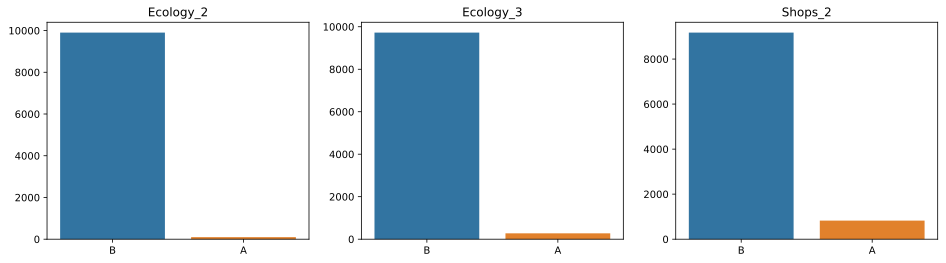

In [70]:
plt.figure(figsize = (16,4))

for i, colname in enumerate(obj_features):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [71]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



In [72]:
#Так как признаки принимают всего два значения, заменим их на бинарные признаки.
obj_to_bool(obj_features, df)

In [73]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



In [74]:
#Признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.
df.drop(['Healthcare_1'], axis=1, inplace=True)

In [75]:
#Исследуем значения признаков LifeSquare и Square. 
df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [76]:
df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

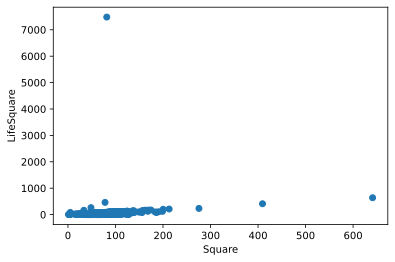

In [77]:
draw_scatter('Square', 'LifeSquare', df)

In [78]:
#Так как оба признака имеют выбросы избавляемся от них.
drop_by_IQ('Square', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.


In [79]:
drop_by_IQ('LifeSquare', df)

For column LifeSquare
	IQ:	21.756925644753355
	LOW:	-9.940131635100524
	HIGH:	77.08757094391291

Lost 1.91% of data.


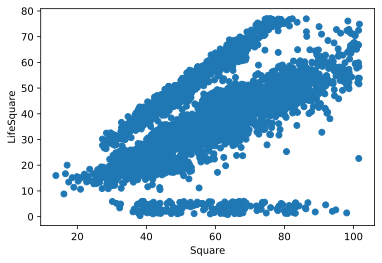

In [80]:
draw_scatter('Square', 'LifeSquare', df)

In [81]:
# Найдём долю жилой площади от общей по средним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378520569631749

In [82]:
fill_life_square(df, square_coeff)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9572 non-null   int64  
 1   DistrictId     9572 non-null   int64  
 2   Rooms          9572 non-null   float64
 3   Square         9572 non-null   float64
 4   LifeSquare     9572 non-null   float64
 5   KitchenSquare  9572 non-null   float64
 6   Floor          9572 non-null   int64  
 7   HouseFloor     9572 non-null   float64
 8   HouseYear      9572 non-null   int64  
 9   Ecology_1      9572 non-null   float64
 10  Ecology_2      9572 non-null   bool   
 11  Ecology_3      9572 non-null   bool   
 12  Social_1       9572 non-null   int64  
 13  Social_2       9572 non-null   int64  
 14  Social_3       9572 non-null   int64  
 15  Helthcare_2    9572 non-null   int64  
 16  Shops_1        9572 non-null   int64  
 17  Shops_2        9572 non-null   bool   
 18  Price   

In [84]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9.572000e+03,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000
mean,8382.207376,50.579816,1.845905,54.118859,34.519826,6.243105,8.471061,12.586293,4.079251e+03,0.119942,24.914333,5390.685959,8.029461,1.327518,4.237986,209182.371820
std,4856.596405,43.768356,0.809624,15.594497,13.030713,29.065509,5.168552,6.628252,2.049338e+05,0.119592,17.488685,3994.347092,23.702448,1.485634,4.792616,87271.970772
min,2.000000,0.000000,0.000000,13.784865,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.500000,19.000000,1.000000,41.537091,24.065821,1.000000,4.000000,9.000000,1.973000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,151904.418474
50%,8390.500000,36.000000,2.000000,51.217517,32.871722,6.000000,7.000000,12.000000,1.977000e+03,0.075779,25.000000,5285.000000,2.000000,1.000000,3.000000,189610.138453
75%,12591.250000,77.000000,2.000000,64.293638,43.319537,9.000000,12.000000,17.000000,1.999000e+03,0.195781,36.000000,7287.000000,5.000000,2.000000,6.000000,244221.524382
max,16798.000000,209.000000,19.000000,102.032801,77.052978,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


In [85]:
# Признак KitchenSquare содержит выбросы, избавляемся от них.
replace_by_IQ('KitchenSquare', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


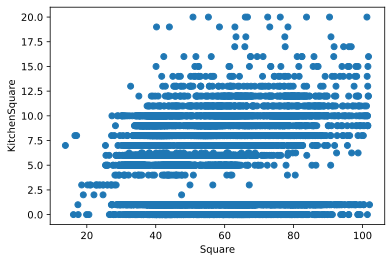

In [86]:
draw_scatter('Square', 'KitchenSquare', df)

In [87]:
#Признак HouseYear содержит выпадающие значения. Обработаем их.
mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [88]:
clean_year(df, mean_year)

In [89]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

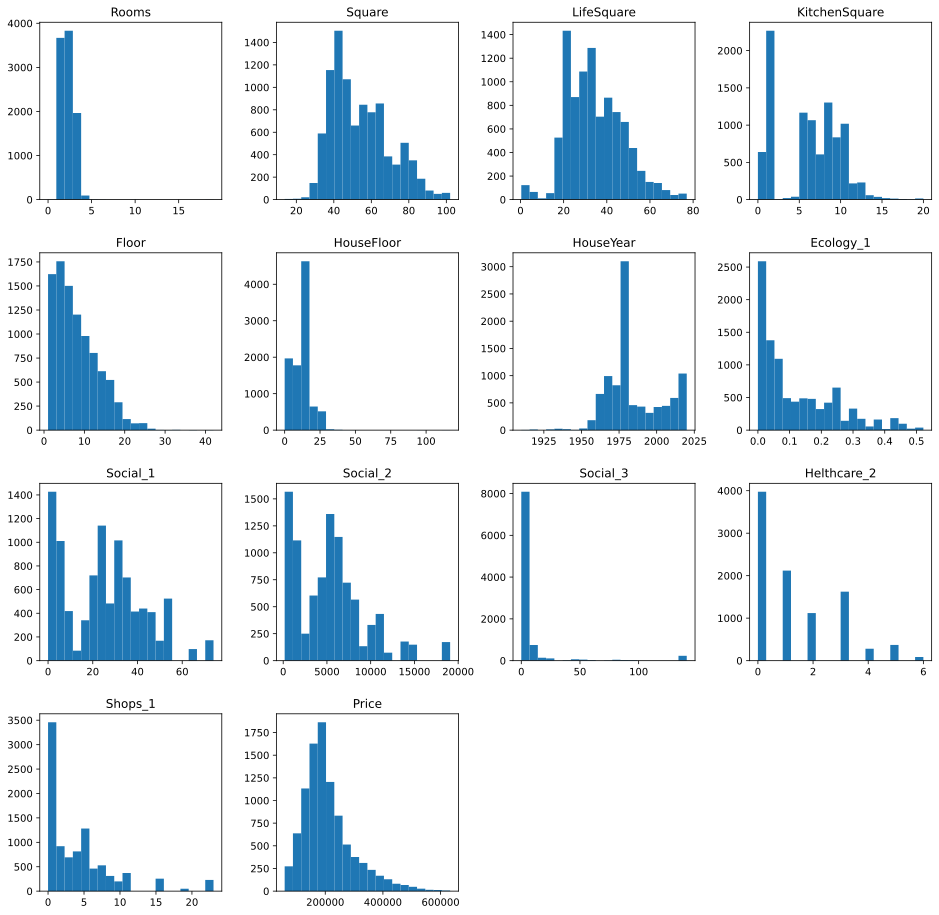

In [90]:
#Cмотрим получившийся результат,проверяем на наличие выбросов.
#Выбросы не наблюдаются.
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [91]:
#Аналогичную обработку проводим с TEST_DATASET_PATH :
#- меняем категориальные признаки на бинарные
#- исключяем из анализа признак Healthcare_1
#- меняем выбросы по признакам Square и LifeSquare на средние значения
test = pd.read_csv(TEST_DATASET_PATH)
obj_to_bool(obj_features, test)
test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)
fill_life_square(test, square_coeff)
replace_by_IQ('KitchenSquare', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.44950036381242
In 110 row Square was replaced to 56.44950036381242.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	36.15881045508673
In 118 row LifeSquare was replaced to 36.15881045508673.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.


In [92]:
# Разобьем TEST_DATASET_PATH на тестовый и валидационный.
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [93]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
X_test = test[features]
X_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,False,False,11,2748,1,0,0,False
1,2.0,69.263183,44.179664,1.0,6,1.0,1977,0.075779,False,False,6,1437,3,0,2,False
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,False,False,30,7538,87,5,5,False
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,False,False,23,4583,3,3,3,False
4,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,False,False,2,629,1,0,0,True


In [96]:
# Масштабируем данные.
scaler = StandardScaler()

In [97]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

In [98]:
#Наилучший результат был получен на модели RandomForestRegressor 
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.8180479489416015, mae_train: 24423.64148174446
r2_test = 0.6798130124073907, mae_test: 30101.821074082596


In [99]:
#Предсказываем цены для тестового датасета
price = model.predict(X_test_scaled)

In [101]:
#Путь к файлу с получившимися прогнозами
TEST_DATASET_EXT_PATH = 'TiulkevichOV_predictions.csv'

In [102]:
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)